## Introduction & overview
- This notebook walks through the baseline implementation of baseline U-Net model [from original paper](https://arxiv.org/abs/1505.04597). Implementation was inspired from [Kaggle grandmaster himself](https://www.youtube.com/watch?v=u1loyDCoGbE&t=2s).</br>
- The dataset used to train the model is taken from [this github repository](https://github.com/zhixuhao/unet/tree/master/data/membrane). For training this model, additional images were also generated which are available in this repository as well along with original 30 images provided in the [github repo](https://github.com/zhixuhao/unet/tree/master/data/membrane).</br>
- The dataloader is mostly inspired by the fastai DataBlock API [see fastai lesson 11](https://course19.fast.ai/videos/?lesson=11) and [follow notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl2/08_data_block.ipynb) for more details. A dataloader was developed inspired from these lessons and notebooks as it makes the much easier. Shout out to the [fastai team](https://www.fast.ai/about/#founders) for these invaluable teachings!

In [37]:
# # mount gdrive if required
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# basic imports
from fastai.basics import *
import PIL,os,mimetypes
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
from torch.nn import functional as F
import time
import os
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [4]:
# set the seed for experiment
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
random.seed(123)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

In [5]:
# Define the path for dataset

os.chdir('/content/drive/My Drive/DL practice Projects/UNet')

Config.DEFAULT_CONFIG = {
        'data_path': '/content/drive/My Drive/DL practice Projects/UNet',
        'model_path': '/content/drive/My Drive/DL practice Projects/models'
    }

Config.create('/tmp/myconfig.yml')
Config.DEFAULT_CONFIG_PATH = '/tmp/myconfig.yml'

path = Config().data_path()

## Dataset
- The original dataset [this github repository](https://github.com/zhixuhao/unet/tree/master/data/membrane) seems to have a small subset ~ 30 training images and corresponding labelled mask images which were also used in original paper for training purposes.
- Now, since the dataset is a tad bit small to begin training, so came the data augmentation to the rescue. All I did was - just rotate the orignal image by 90, 180, 270 degress (same for the label images) and saved these new images accordingly. A notebook `Unet_Data_augmentation.ipynb` is available in this repo.
- The `train/image` and `train/label` path contains in total 120 training and label images respectively.


In [6]:
path_train_img = path/'data/membrane/train/image' # training image data path
path_train_lbl = path/'data/membrane/train/label' # label image data path

In [7]:
# read the filenames
fnames = sorted(get_image_files(path_train_img))
lbl_names = sorted(get_image_files(path_train_lbl))

In [8]:
len(fnames), len(lbl_names)

(120, 120)

# Dataloader  [inspired from FastAI](https://github.com/fastai/course-v3/blob/master/nbs/dl2/08_data_block.ipynb)

**Why databloack API?**
- The datablock API defines a systematic way to prepare the data for model.
- Depending on the need, one might perform this routine for data pre-processing
  1. Get all the items from path or a folder
  2. Processing the items (such as normalization)
  (Optional) Doing some Augmentation
  3. Transform items into tensors
  4. Splitting the items into training and validation sets
  e.g. random fraction, folder name, CSV, …
  5. Labelling the items,
  e.g. from folder name, file name/re, CSV, …
  6. Make data into batches (DataLoader)
  (Optional) Transform per batch
  7. Combine the DataLoaders together into a DataBunch
  (Optional) Add a test set


### Step 1 to 3: Get items from folder, apply transforms...
> First we create a list contained to store all path objects in once place and have a way to access them or perform actions on them (like slicing, indexing directly into them, etc.) This will come in handy, as we don't need to load the data into the memory yet, but still the each item can be acccessed at your whim!!!

In [9]:
class ListContainer():
  def __init__(self,items): self.items = listify(items) # initialize the items as list; late we can perform operations on this list
  def __len__(self): return len(self.items) #get the length of item
  def __iter__(self): return iter(self.items)  # get the iteratable function on this list
  def __setitem__(self, i, o): self.items[i] = o # notice that this don't return anything, and are in place
  def __delitem__(self, i): del(self.items[i]) # notice that this don't return anything, and are in place
  def __getitem__(self, idx):
    if isinstance(idx, (int,slice)): return self.items[idx]
    if isinstance(idx[0], bool):
      assert len(idx) == len(self.items) # make sure that the bool size is same as self.items size
      return [o for m, o in zip(idx, self.items) if m]
    return [self.items[i] for i in idx]
  def __repr__(self):
    res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
    if len(self)>10: res = res[:-1] + '...]'
    return res


> Now, we create a base class called **ItemList** that has a **get** method, which subclasses override. We will use this **get** method and apply a sequence of transforms (like converting to float tensor, normalizing, etc.) to each image as a part of data preparation step.

> In summary, ItemList:

- Is a list of items and a path where they came from

- Optionally has a list of transforms, which are functions.

- The list of transforms is composed and applied every time you **get** and item. So you get back a transformed item every time.

> This **compose function**: takes a list of functions and combines them into a pipeline that chains the outputs of the first function to input of the second and so on. In other words, a deep neural network is just a composition of functions (layers). As a one-liner:
```python
for fn in fns: x = fn(x)
```

In [10]:
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
  def __init__(self, items, path = '.', tfms = None):
    super().__init__(items)
    self.path, self.tfms = Path(path), tfms

  def __repr__(self):
    return f'{super().__repr__()} \nPath: {self.path}'

  def new(self, items, cls = None):
    if cls is None: cls = self.__class__
    return cls(items, self.path, tfms = self.tfms)

  def get(self, i): return i
  def _get(self, i): return compose(self.get(i), self.tfms)

  def __getitem__(self,idx):
    res = super().__getitem__(idx)
    if isinstance(res, list): return [self._get(o) for o in res]
    return self._get(res)

- Here, we define a new class **ImageList** which inherites from baseclass ItemList and has a get method which will be used to read the train or lbl image and then covert the image to float tensor (Yup, we're into Torch domain now..you know where this is headed!)

In [11]:
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/')) 

In [12]:
class ImageList(ItemList):
  @classmethod
  def from_files(cls, path, extensions = None, recurse = True, include = None, **kwargs):
    if extensions is None:
      extensions = image_extensions
    return cls(get_files(path, extensions, recurse=recurse, include = include), path, **kwargs)

  def get(sels, fname):
    if 'train/image' in str(fname):
      return open_image(fname).data.float() 
    else: 
      return open_mask(fname).data.float().div_(255.)

### Step 4: Split data

- A simple train / valid split of 80/20 % was used to split the dataset using helper function `split_by_fac`

In [13]:
def split_by_fac(items, fac = 0.2):
  split_factor = round(fac*len(items)) # this will be the validation image size
  t = items[:(len(items)-split_factor)]
  v = items[-split_factor:]
  return t, v

In [14]:
class SplitData():
  def __init__(self, train, valid): self.train, self.valid = train, valid

  def __getattr__(self, k): return getattr(self.train,k)

  def __setstate__(self,data:Any): self.__dict__.update(data)

  @classmethod
  def split_by_factor(cls, il, factor = 0.2):
    lists = map(il.new, split_by_fac(il.items, factor))
    return cls(*lists)
  
  def __repr__(self):
    return f'{self.__class__.__name__}\nTrain:{self.train}\nValid:{self.valid}'

### Step 5:

- Now, we need to define the labels corresponding to each training image. We already know the path to labels, just need to pass the path, and match the file name, and finally create the pair of input image & output label

In [15]:
def _label_from_func(ds, topath, tfms, cls = ImageList):
  # g, _ = split_by_fac(cls.from_files(topath).items)
  return cls([path_train_lbl/(i.stem + '.png') for i in ds.items], path = topath, tfms = tfms)

class LabeledData():
  def __init__(self,x,y):
    self.x, self.y = x, y

  def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}'
  def __len__(self): return len(self.x)
  def __getitem__(self,idx): return self.x[idx], self.y[idx]

  @classmethod
  def label_by_func(cls, il, p, tfms):
    return cls(il, _label_from_func(il,p,tfms))

In [16]:
def label_by_func(sd, path_to_labels, tfms = None):
  
  train = LabeledData.label_by_func(sd.train, path_to_labels, tfms = tfms)
  valid = LabeledData.label_by_func(sd.valid, path_to_labels, tfms = tfms)

  return SplitData(train,valid)

In [17]:
# some tranform functions..these are obsolete as the same functionality was added in ImageList class
def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res#.view(h,w,-1).permute(2,0,1)


def to_float_tensor(item): return item.float().div_(255.)

#### Finally, let's see what we have when we complete the data pipeline after all this work.

In [18]:
# tfms = [to_byte_tensor, to_float_tensor]
tfms = None
il = ImageList.from_files(path_train_img) # image list
sd = SplitData.split_by_factor(il, factor = 0.2) # split data
ll = label_by_func(sd, path_train_lbl) # label data 

# As you see that we have Train and Valid dataset path objects. 
# Each of them has x and y attributes containins corresponding input and output image
ll

SplitData
Train:LabeledData
x: ImageList (96 items)
[PosixPath('/content/drive/My Drive/FASTAI Projects/UNet/unet-master/data/membrane/train/image/24.png'), PosixPath('/content/drive/My Drive/FASTAI Projects/UNet/unet-master/data/membrane/train/image/3.png'), PosixPath('/content/drive/My Drive/FASTAI Projects/UNet/unet-master/data/membrane/train/image/15.png'), PosixPath('/content/drive/My Drive/FASTAI Projects/UNet/unet-master/data/membrane/train/image/18.png'), PosixPath('/content/drive/My Drive/FASTAI Projects/UNet/unet-master/data/membrane/train/image/12.png'), PosixPath('/content/drive/My Drive/FASTAI Projects/UNet/unet-master/data/membrane/train/image/21.png'), PosixPath('/content/drive/My Drive/FASTAI Projects/UNet/unet-master/data/membrane/train/image/25.png'), PosixPath('/content/drive/My Drive/FASTAI Projects/UNet/unet-master/data/membrane/train/image/8.png'), PosixPath('/content/drive/My Drive/FASTAI Projects/UNet/unet-master/data/membrane/train/image/29.png'), PosixPath('/c

### Step 6 and 7: Create data in bunches (DataLoader) and combine dataloaders together into a DataBunch

In [19]:

# class Dataset():
#     def __init__(self, x, y): self.x,self.y = x,y
#     def __len__(self): return len(self.x)
#     def __getitem__(self, i): return self.x[i],self.y[i]


def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs, shuffle=True, **kwargs))

In [20]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl,self.valid_dl,self.c_in,self.c_out = train_dl,valid_dl,c_in,c_out

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

In [21]:
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify # another classmethod added to splitdata class to create databunches using bs (batch_size)

In [22]:
bs = 1
data = ll.to_databunch(bs, c_in=None, c_out=None, num_workers=1)

In [23]:
data.train_dl, data.valid_dl # contains train and validation set dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ff83d104588>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff83d104d30>)

In [24]:
# grab a single batch using get_batch function
def get_batch(dl):
    xb, yb = next(iter(dl))
    return xb,yb

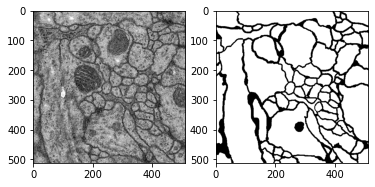

In [25]:
# grab a single image and plot
xb, yb = get_batch(data.valid_dl)
# display the an input and output segmentation mask image
plt.subplot(121)
plt.imshow(xb.squeeze().permute([1,2,0]), cmap = 'gray');
plt.subplot(122)
plt.imshow(yb.squeeze(), cmap = 'gray'); 

# Baseline Unet

- Finally we implement our baseline Unet model
- Additionally, to concatenate the data from downsample branch to upsampling branch, we must crop the tensor from downsample branch, this is done with the help of `crop_tensor` helper function
- Important point to note here is that the output of this model is an image of size [1, 1, 324, 324], as no padding was applied during down sampling and upsampling as well. Hence, we need to crop the training label to match the output of the model itself. There, additional care must be taken while calculate loss and also evaluating the model. A helper function `cros_mask` comes in handy.

In [26]:
def double_conv(in_c, out_c):
    """ Double conv with Relu inbetween"""
    
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3),
        nn.ReLU(inplace=True)
    )
    return conv

# crops the input_tensor size to match the target_tensor size
def crop_img(input_tensor, target_tensor):
    ""

    target_size = target_tensor.size()[2]
    tensor_size = input_tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta//2
    out   = input_tensor[:,:,delta:tensor_size - delta,delta:tensor_size - delta]
    
    if out.size()[2] != target_size:
        #find delta
        factor  = out.size()[2] - target_size
        out     = input_tensor[:,:,delta+factor:tensor_size - delta, delta+factor : tensor_size - delta]

    return out

class Unet(nn.Module):
    ##
    """ Unet class"""
  
    def __init__(self):
        super(Unet,self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size= 2, stride=2)
        self.down_conv_1 = double_conv(3,64)
        self.down_conv_2 = double_conv(64,128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256,512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,kernel_size=2, stride=2)
        self.up_conv1   = double_conv(1024,512)

        self.up_trans2 = nn.ConvTranspose2d(in_channels=512, out_channels=256,kernel_size=2, stride=2)
        self.up_conv2   = double_conv(512,256)

        self.up_trans3 = nn.ConvTranspose2d(in_channels=256, out_channels=128,kernel_size=2, stride=2)
        self.up_conv3   = double_conv(256,128)

        self.up_trans4 = nn.ConvTranspose2d(in_channels=128, out_channels=64,kernel_size=2, stride=2)
        self.up_conv4   = double_conv(128,64)

        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

        self.relu = nn.ReLU()
    
    def forward(self,image):

        # Encoder (can be a pre-trained imagenet)
        # image size for batch 1 = bs, c, h, w
        x1 = self.down_conv_1(image) # 
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2) #
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4) #
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6) #
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)

        # Decoder
        x = self.up_trans1(x9)
        y = crop_img(x7,x)
        x = self.up_conv1(torch.cat([x,y], dim = 1))

        x = self.up_trans2(x)
        y = crop_img(x5,x)
        x = self.up_conv2(torch.cat([x,y], dim = 1))

        x = self.up_trans3(x)
        y = crop_img(x3,x)
        x = self.up_conv3(torch.cat([x,y], dim = 1))

        x = self.up_trans4(x)
        y = crop_img(x1,x)
        x = self.up_conv4(torch.cat([x,y], dim = 1))
      
        x = self.out(x)
        
        return x

# Learner

- I think it's much better to cook up a UnetLearner in order to make the model training and experimentation a bit easier.<br/> 
- Behold the UnetLearner class!!
- Adding callbacks would definitely add more functionality, but at the moment we just stick to the basics

In [27]:
class UnetLearner():

  def __init__(self, dataset, model, loss_func, metrics = None):

    self.dataset        = dataset
    self.model          = model
    self.loss_func      = loss_func
    self.metrics        = metrics
    self.train_losses   = []
    self.valid_losses   = []
    self.acc            = []
    self._model_init(model) # initialize the weights of model

  def init_weights(self,m):
      if (type(m) == nn.Conv2d) or (type(m) == nn.ConvTranspose2d):
          torch.nn.init.kaiming_normal_(m.weight)
          m.bias.data.fill_(0.)

  def _model_init(self,model):
    self.model.apply(self.init_weights)
    
  
  def update(self,input_image,mask_image, lr):
    opt   = optim.Adam(model.parameters(), lr = lr) # define optimizer
    # forward pass of the model
    y_hat = model(input_image)

    # compute loss
    loss = self.loss_func(y_hat,mask_image)
    
    # backward pass
    loss.backward()
    opt.step() # update parameters
    opt.zero_grad() # set parameters grads to zero
    
    return loss.item()


  def fit(self, epochs: int, lr, weigth_decays):
    self.model.train()
    print('Here we go!')
    # train loop
    for epch in range(epochs):
      for i in range(len(self.dataset.train_dl)):
        x, y = get_batch(self.dataset.train_dl)
        if torch.cuda.is_available():
          x, y  = x.cuda(), y.cuda()
        self.train_losses.append(self.update(x,y,lr))


      self.model.eval()
      with torch.no_grad():
        for j in range(len(self.dataset.valid_dl)):
          xv, yv = get_batch(self.dataset.train_dl)
          if torch.cuda.is_available():
            xv, yv = xv.cuda(), yv.cuda()
          pred = self.model(xv)
          self.valid_losses.append(self.loss_func(pred, yv))

      nv = len(self.dataset.valid_dl)
      nt = len(self.dataset.train_dl)
      print("Epoch number {} finished.".format(epch))
      print("Training loss: {:.2f}, Validation loss: {:.2f}".format(sum(self.train_losses[-nt:])/nt, sum(self.valid_losses[-nv:])/nv))

    return None
  
  def plot_losses(self):
    plt.figure(figsize=(15, 4))
    plt.subplot(121)
    plt.plot(self.train_losses)
    plt.title('Training Losses')
    plt.subplot(122)
    plt.plot(self.valid_losses)
    plt.title('Validation Losses')
    plt.show()
    return None
  
  def eval_and_plotImages(self, imageId = None):
  
    if imageId == None:
      # get any image from validation dataset
      test_img, lbl_img = get_batch(data.valid_dl)
      test_img.size(), lbl_img.size()

    with torch.no_grad():
    # just evaluate a single image
        test_img = test_img.cuda()
        lbl_img = lbl_img.cuda()
        self.model.eval()
        predicted_img = torch.sigmoid(self.model(test_img))

    
    fig=plt.figure(figsize=(15,15))
    # train image
    plt.subplot(131)
    ax= plt.gca()
    im = ax.imshow(test_img.cpu().squeeze().permute([1,2,0]))
    ax.set_title('Training Input Image')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.colorbar(im,fraction=0.046, pad=0.04)

    #labeled image
    plt.subplot(132)
    ax= plt.gca()
    im = ax.imshow(crop_mask(lbl_img.cpu(), predicted_img).squeeze(),cmap = 'gray')
    ax.set_title('Cropped mask image')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.colorbar(im,fraction=0.046, pad=0.04)

    #predicted labelled image
    plt.subplot(133)
    ax= plt.gca()
    im = ax.imshow(predicted_img.cpu().detach().squeeze(), cmap = 'gray')
    ax.set_title('PREDICTED cropped mask image')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.colorbar(im,fraction=0.046, pad=0.04)
    fig.tight_layout()  
    plt.show()

    plt.figure(figsize=(8,8))
    plt.imshow(crop_mask(test_img,predicted_img).cpu().squeeze().permute([1,2,0]),cmap = 'jet',interpolation='none')
    plt.imshow(predicted_img.cpu().detach().squeeze(), cmap = 'jet',interpolation='none',alpha = 0.3)
    plt.title('Test image and predicted segmentation mask')
    plt.show()
    
    return None


In [28]:
# Helper function to match the mask image size from model output and expected segementation mask image
def crop_mask(input_mask_image,target_mask_image):
  mask_size = input_mask_image.size()[2] 
  output_size = target_mask_image.size()[2]
  delta = (mask_size - output_size)//2
  return input_mask_image[:,:,delta:mask_size - delta,delta:mask_size - delta]


### Define loss function (this is a combination of binary cross entropy and dice loss)

In [29]:

def dice_loss(input, target):
  smooth = 1.
  iflat = input.flatten()
  tflat = target.flatten()
  intersection = (iflat * tflat).sum()

  return 1.0 - (((2. * intersection + smooth) /
            (iflat.sum() + tflat.sum() + smooth)))


class Unet_Loss(nn.Module):

  def __init__(self):
    super().__init__()
    self.loss_BCE = nn.BCEWithLogitsLoss()

    

  def forward(self,y_hat, mask_image):
    cropped_image  = crop_mask(mask_image,y_hat)
    totloss = self.loss_BCE(y_hat,cropped_image) + dice_loss(torch.sigmoid(y_hat), cropped_image)
    return totloss


### Create model instance and start training...

In [34]:
if 'model' in locals():
  del model
if torch.cuda.is_available(): 
  model  = Unet().cuda()
else: model = Unet()
loss_func = Unet_Loss()


In [35]:
learn = UnetLearner(data, model,loss_func = loss_func)
learn.fit(25,1e-4, 0.) # batch size = 1

Here we go!
Epoch number 0 finished.
Training loss: 0.56, Validation loss: 0.51
Epoch number 1 finished.
Training loss: 0.44, Validation loss: 0.39
Epoch number 2 finished.
Training loss: 0.38, Validation loss: 0.35
Epoch number 3 finished.
Training loss: 0.37, Validation loss: 0.36
Epoch number 4 finished.
Training loss: 0.34, Validation loss: 0.34
Epoch number 5 finished.
Training loss: 0.33, Validation loss: 0.32
Epoch number 6 finished.
Training loss: 0.32, Validation loss: 0.29
Epoch number 7 finished.
Training loss: 0.32, Validation loss: 0.31
Epoch number 8 finished.
Training loss: 0.32, Validation loss: 0.30
Epoch number 9 finished.
Training loss: 0.30, Validation loss: 0.28
Epoch number 10 finished.
Training loss: 0.31, Validation loss: 0.29
Epoch number 11 finished.
Training loss: 0.31, Validation loss: 0.38
Epoch number 12 finished.
Training loss: 0.29, Validation loss: 0.28
Epoch number 13 finished.
Training loss: 0.28, Validation loss: 0.25
Epoch number 14 finished.
Traini

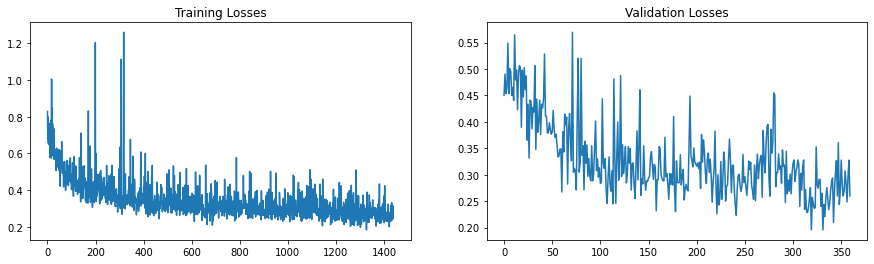

In [32]:
#plot training and validation separately
learn.plot_losses()

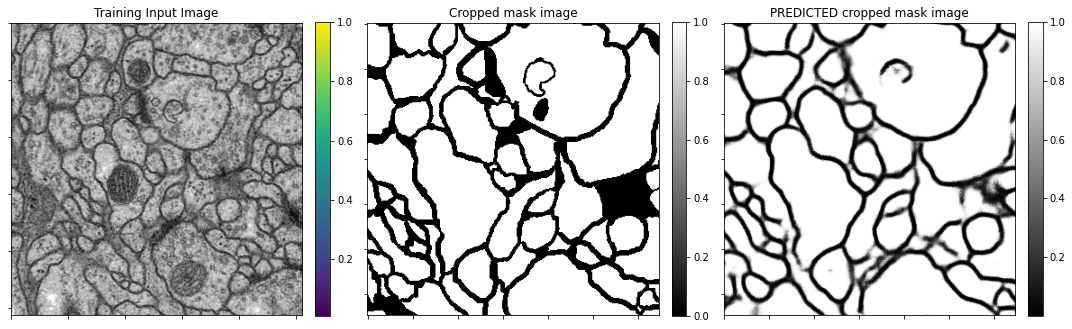

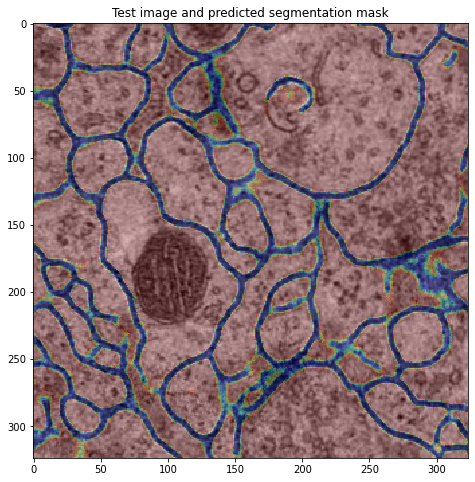

In [36]:
learn.eval_and_plotImages()

> finish